In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from Utilities import PlotImages

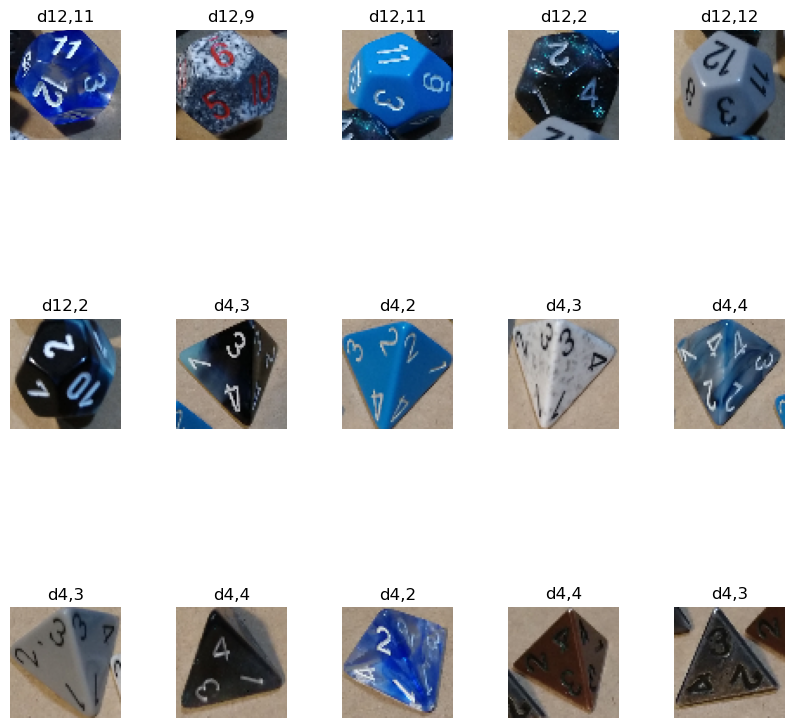

In [2]:
data = np.load("/work/MA490_DeepLearning/Share/Dice/CleanedDiceData64.npz", allow_pickle=True)
images = data["images"]
labels = data["labels"]
PlotImages(2000, 15, 3, 5, images, labels)
plt.show()

In [3]:
X = images
y = np.array(list(map(lambda x: x.split(",")[0], labels)))
X.shape

(2768, 64, 64, 3)

In [4]:
pd.Series(y).value_counts()

d6     542
d%     458
d4     446
d12    402
d10    397
d8     305
d20    217
d7       1
dtype: int64

In [5]:
idx = list(y).index("d7")
print(idx)
X = np.delete(X, idx, axis=0)
y = np.delete(y, idx)
pd.Series(y).value_counts()

2282


d6     542
d%     458
d4     446
d12    402
d10    397
d8     305
d20    217
dtype: int64

In [6]:
# for i in range(len(y)):
#     if y[i] == "d%":
#         y[i] = "d10"

In [7]:
pd.Series(y).value_counts()

d6     542
d%     458
d4     446
d12    402
d10    397
d8     305
d20    217
dtype: int64

In [8]:
label_names = ["d4", "d6", "d8", "d10", "d12", "d20", "d%"]

In [9]:
y = np.array([label_names.index(x) for x in y])

In [10]:
pd.Series(y).value_counts()

1    542
6    458
0    446
4    402
3    397
2    305
5    217
dtype: int64

In [11]:
def BuildVGG(input_shape=(32,32,3),outputs=10):
    model = Sequential()
    model.add(Conv2D(input_shape=input_shape,filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
    model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(Flatten())
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=4096,activation="relu"))
    model.add(Dense(units=outputs, activation="softmax"))
    return model

In [12]:
def buildCustomModel(input_shape, output, convolutionalRegions=5, layersInRegion=3):
    model = Sequential()
    
    model.add(Conv2D(10,3,
                     padding='same', 
                     input_shape=input_shape,
                     activation='relu'))
    
    for regionNum in range(convolutionalRegions):
        for layerNum in range(layersInRegion):
            model.add(Conv2D((2**(regionNum+1))*10,3,
                     padding='same',
                     activation='relu'))
        model.add(Dropout(.15))
        model.add(MaxPooling2D(pool_size=(2,2),
                     strides=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dense(200))
    model.add(Activation('relu'))
    model.add(Dense(output,
                     activation='softmax'))
    return model

In [13]:
###################
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
###################

In [14]:
customModel = BuildVGG((64,64,3), 7)
# customModel = buildCustomModel((64,64,3), 7, 5, 2)

customModel.compile(loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0001),
        metrics=['accuracy'])

In [15]:
checkpt = ModelCheckpoint("best_dice_type",
                         save_best_only=True,
                         verbose=0)

In [16]:
customModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 64)        36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 128)       147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 256)       2

In [17]:
with tf.device('/device:GPU:3'):
    hist = customModel.fit(X,y,
            callbacks=[checkpt],
            epochs=50,
            validation_split=0.2,
            verbose=2)

Epoch 1/50
70/70 - 152s - loss: 1.8603 - accuracy: 0.2286 - val_loss: 1.5542 - val_accuracy: 0.3466
INFO:tensorflow:Assets written to: best_dice_type/assets
Epoch 2/50
70/70 - 3s - loss: 1.5597 - accuracy: 0.3502 - val_loss: 1.3817 - val_accuracy: 0.4404
INFO:tensorflow:Assets written to: best_dice_type/assets
Epoch 3/50
70/70 - 3s - loss: 1.4371 - accuracy: 0.4162 - val_loss: 1.4147 - val_accuracy: 0.4603
Epoch 4/50
70/70 - 3s - loss: 1.2804 - accuracy: 0.4749 - val_loss: 1.3490 - val_accuracy: 0.5018
INFO:tensorflow:Assets written to: best_dice_type/assets
Epoch 5/50
70/70 - 3s - loss: 1.1470 - accuracy: 0.5432 - val_loss: 0.9970 - val_accuracy: 0.6191
INFO:tensorflow:Assets written to: best_dice_type/assets
Epoch 6/50
70/70 - 3s - loss: 0.9952 - accuracy: 0.6037 - val_loss: 0.9378 - val_accuracy: 0.6480
INFO:tensorflow:Assets written to: best_dice_type/assets
Epoch 7/50
70/70 - 3s - loss: 0.8468 - accuracy: 0.6674 - val_loss: 0.9653 - val_accuracy: 0.6354
Epoch 8/50
70/70 - 3s - los

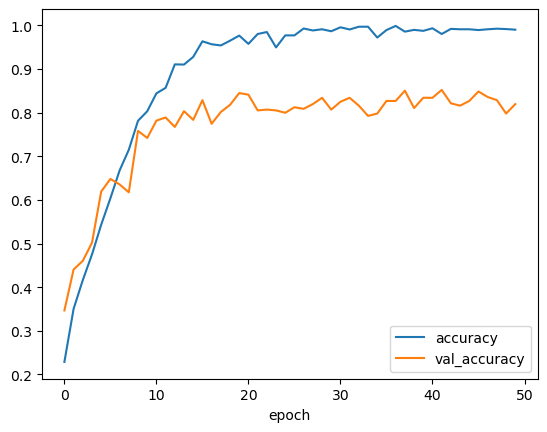

In [21]:
results = pd.DataFrame()
results["epoch"] = hist.epoch
results["accuracy"] = hist.history["accuracy"]
results["val_accuracy"] = hist.history["val_accuracy"]
plot1 = results.plot.line(x="epoch", y="accuracy")
results.plot.line(x="epoch", y="val_accuracy", ax=plot1)
plt.show()